In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from bs4 import BeautifulSoup


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

py.init_notebook_mode(connected=True)

In [11]:
df = pd.read_csv('mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [12]:
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))
df.head()

,type,posts,words_per_comment,variance_of_word_counts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,11,135.2900
1,ENTP,'I'm finding the lack of me in these posts ver...,23,187.4756
2,INTP,'Good one _____ https://www.youtube.com/wat...,16,180.6900
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",21,181.8324
4,ENTJ,'You're fired.|||That's another silly misconce...,19,196.4576


In [13]:
df.groupby('type').agg({'type':'count'})

,type
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


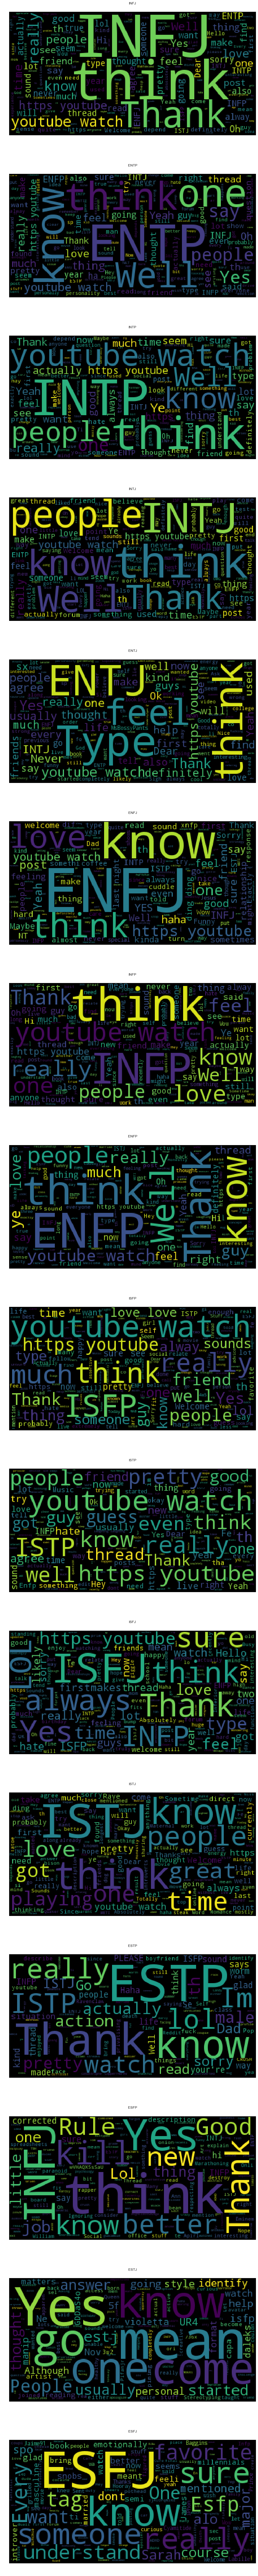

In [14]:
from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS

fig, ax = plt.subplots(len(df['type'].unique()), sharex=True, figsize=(15,10*len(df['type'].unique())))

k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud().generate(df_4['posts'].to_string())
    ax[k].imshow(wordcloud)
    ax[k].set_title(i)
    ax[k].axis("off")
    k+=1

In [18]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    return text
df['clean_posts'] = df['posts'].apply(cleanText)

In [19]:
df.to_csv("clean.csv", encoding='utf-8', index=True)